# Implementasi Klasifikasi Penyakit Daun Kopi Menggunakan Vision Transformer (ViT), LoRA Fine-Tuning, dan Explainable AI (Grad-CAM & Groq LLM)

## Vision Transformer (ViT)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

data_root = '/content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split'
splits = ['train', 'val', 'test']

print('\n'.join([f"{split}: {os.listdir(os.path.join(data_root,split))}" for split in splits]))
classes = sorted(os.listdir(os.path.join(data_root, 'train')))
print("Kelas:", classes)


train: ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
val: ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
test: ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
Kelas: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']


TRAIN: {'Daun_Bercak': 1200, 'Daun_Karat': 1200, 'Daun_Sehat': 1200}
VAL: {'Daun_Bercak': 150, 'Daun_Karat': 150, 'Daun_Sehat': 150}
TEST: {'Daun_Bercak': 150, 'Daun_Karat': 150, 'Daun_Sehat': 150}


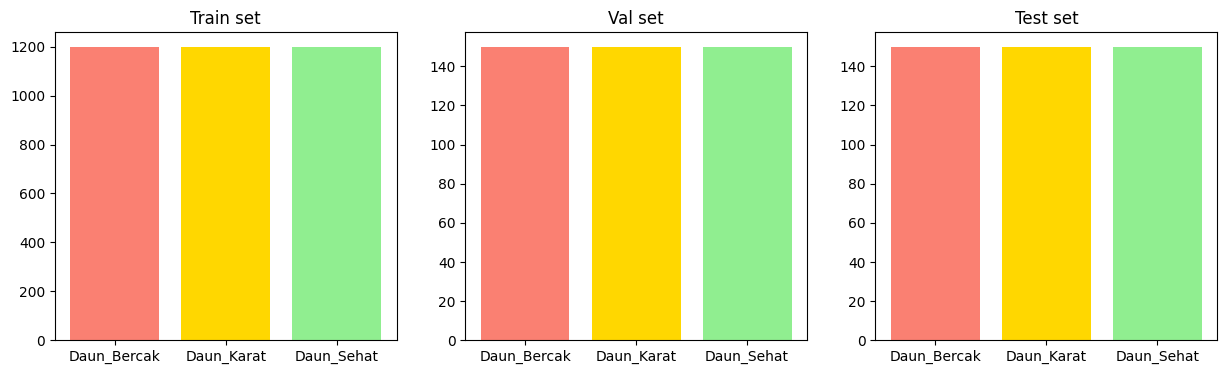

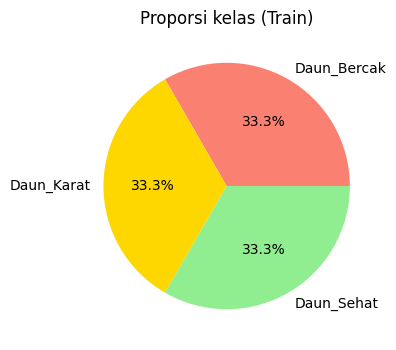

In [ ]:
import matplotlib.pyplot as plt

class_counts = {}
for split in splits:
    folder = os.path.join(data_root, split)
    class_counts[split] = {cls: len(os.listdir(os.path.join(folder, cls)))
                           for cls in classes if os.path.isdir(os.path.join(folder, cls))}
    print(f'{split.upper()}:', class_counts[split])

fig, axs = plt.subplots(1, 3, figsize=(15,4))
colors = ['salmon', 'gold', 'lightgreen'] if len(classes)==3 else None
for i, split in enumerate(splits):
    axs[i].bar(class_counts[split].keys(), class_counts[split].values(), color=colors)
    axs[i].set_title(f'{split.capitalize()} set')
plt.show()

plt.figure(figsize=(4,4))
plt.pie(list(class_counts['train'].values()), labels=class_counts['train'].keys(), autopct='%1.1f%%', colors=colors)
plt.title('Proporsi kelas (Train)')
plt.show()


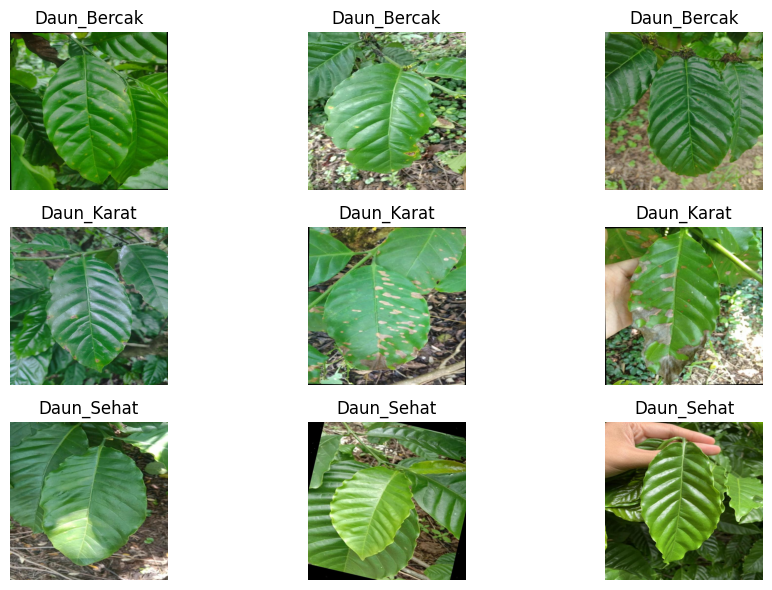

In [ ]:
import matplotlib.image as mpimg

num_samples = 3
plt.figure(figsize=(10, len(classes)*2))
for i, cls in enumerate(classes):
    folder = os.path.join(data_root, 'train', cls)
    imgs = os.listdir(folder)[:num_samples]
    for j, imgf in enumerate(imgs):
        ax = plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
        img = mpimg.imread(os.path.join(folder, imgf))
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
import numpy as np

sizes, modes = [], []
sample_kelas = classes
for cls in sample_kelas:
    class_folder = os.path.join(data_root, 'train', cls)
    for f in os.listdir(class_folder)[:15]:
        img_path = os.path.join(class_folder, f)
        with Image.open(img_path) as img:
            sizes.append(img.size)
            modes.append(img.mode)
sizes = np.array(sizes)
print("Rata-rata ukuran (WxH):", np.mean(sizes, axis=0).astype(int))
print("Min:", np.min(sizes, axis=0), "Max:", np.max(sizes, axis=0))
print("Tipe gambar ditemukan:", set(modes))


Rata-rata ukuran (WxH): [640 640]
Min: [640 640] Max: [640 640]
Tipe gambar ditemukan: {'RGB'}


Histogram channel warna:


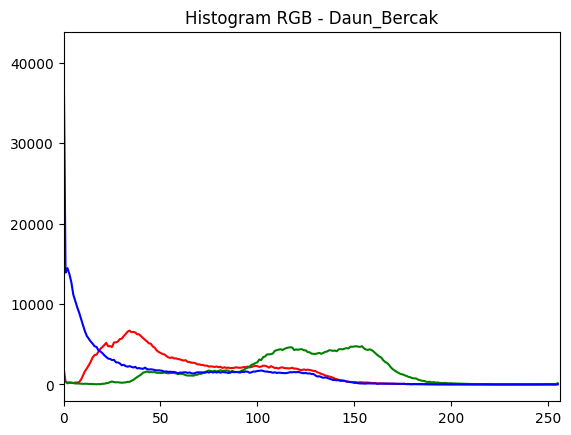

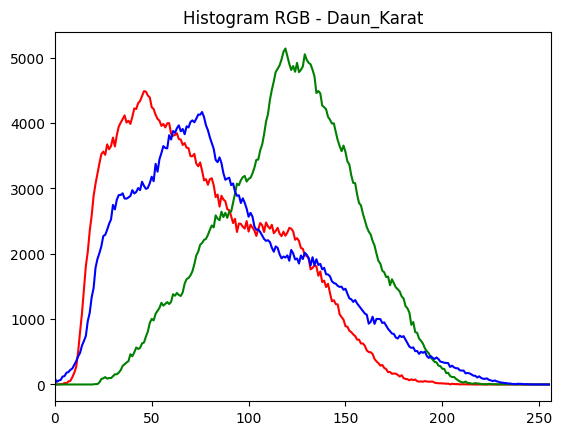

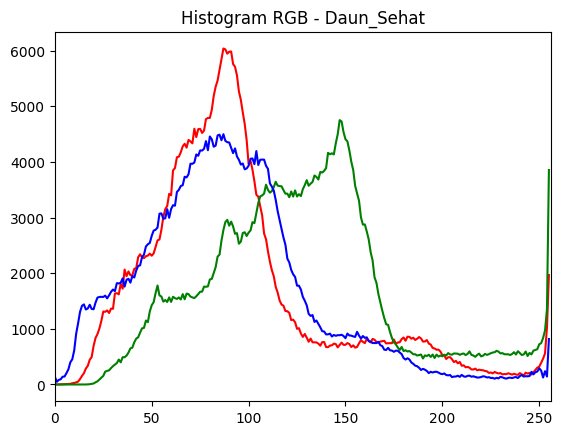

In [ ]:
import cv2

def plot_histogram_rgb(image_path, kelas):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color = ('r','g','b')
    for i, col in enumerate(color):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist, color=col)
    plt.title(f"Histogram RGB - {kelas}")
    plt.xlim([0,256])
    plt.show()

print("Histogram channel warna:")
for cls in classes:
    f = os.listdir(os.path.join(data_root,'train',cls))[0]
    sample_img = os.path.join(data_root,'train',cls,f)
    plot_histogram_rgb(sample_img, cls)


In [ ]:
from PIL import ImageStat

def is_blurry(image_path, threshold=20):
    img = Image.open(image_path).convert('L')
    stat = ImageStat.Stat(img)
    return stat.stddev[0] < threshold

for cls in classes:
    class_folder = os.path.join(data_root,'train',cls)
    blurs = []
    for f in os.listdir(class_folder)[:20]:
        img_path = os.path.join(class_folder,f)
        if is_blurry(img_path):
            blurs.append(f)
    print(f'Kelas {cls}: {len(blurs)} gambar dideteksi buram (sample: {blurs[:2]})')


Kelas Daun_Bercak: 0 gambar dideteksi buram (sample: [])
Kelas Daun_Karat: 0 gambar dideteksi buram (sample: [])
Kelas Daun_Sehat: 0 gambar dideteksi buram (sample: [])


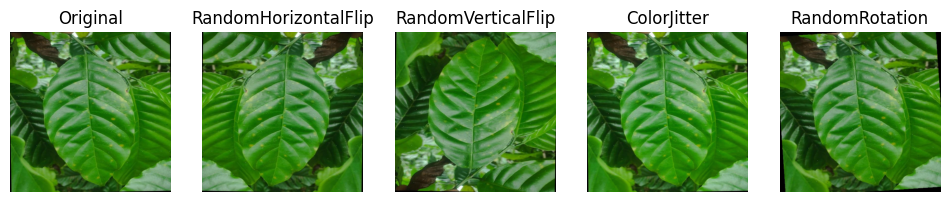

In [ ]:
import torchvision.transforms as T

sample_img_path = os.path.join(data_root,'train',classes[0],os.listdir(os.path.join(data_root,'train',classes[0]))[0])
image = Image.open(sample_img_path)
augments = [
    T.RandomHorizontalFlip(p=1),
    T.RandomVerticalFlip(p=1),
    T.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4),
    T.RandomRotation(30)
]

plt.figure(figsize=(12,3))
plt.subplot(1,5,1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')
for ix, tf in enumerate(augments):
    aug_img = tf(image)
    plt.subplot(1,5,ix+2)
    plt.imshow(aug_img)
    plt.title(tf.__class__.__name__)
    plt.axis('off')
plt.show()


In [ ]:
!pip install -q transformers datasets timm scikit-learn
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score


In [ ]:
data_files = {
    "train": os.path.join(data_root, "train", "**"),
    "validation": os.path.join(data_root, "val", "**"),
    "test": os.path.join(data_root, "test", "**")
}
dataset = load_dataset("imagefolder", data_files=data_files)
labels = dataset['train'].features['label'].names
print("Kelas label:", labels)


Resolving data files:   0%|          | 0/3600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/450 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/450 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Kelas label: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']


In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): lbl for i, lbl in enumerate(labels)},
    label2id={lbl: str(i) for i, lbl in enumerate(labels)}
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
def transform(example):
    img = example["image"].convert("RGB")
    inputs = image_processor(img, return_tensors="pt")
    result = {k: v.squeeze() for k, v in inputs.items()}
    result["label"] = example["label"]
    return result

prepared_ds = {}
for split in ["train", "validation", "test"]:
    prepared_ds[split] = dataset[split].map(transform)


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-daunkopi-checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    learning_rate=3e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()


/tmp/ipython-input-1416078788.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.129000,0.088814,0.986667
2,0.058100,0.077586,0.980000
3,0.055300,0.066345,0.986667
4,0.032800,0.066856,0.984444
5,0.013200,0.077670,0.982222


TrainOutput(global_step=1125, training_loss=0.08850089281797409, metrics={'train_runtime': 2693.6193, 'train_samples_per_second': 6.682, 'train_steps_per_second': 0.418, 'total_flos': 1.394868314714112e+18, 'train_loss': 0.08850089281797409, 'epoch': 5.0})

Sedang melakukan prediksi pada data test...



CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Daun_Bercak       0.96      0.96      0.96       150
  Daun_Karat       0.99      0.97      0.98       150
  Daun_Sehat       0.97      0.99      0.98       150

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



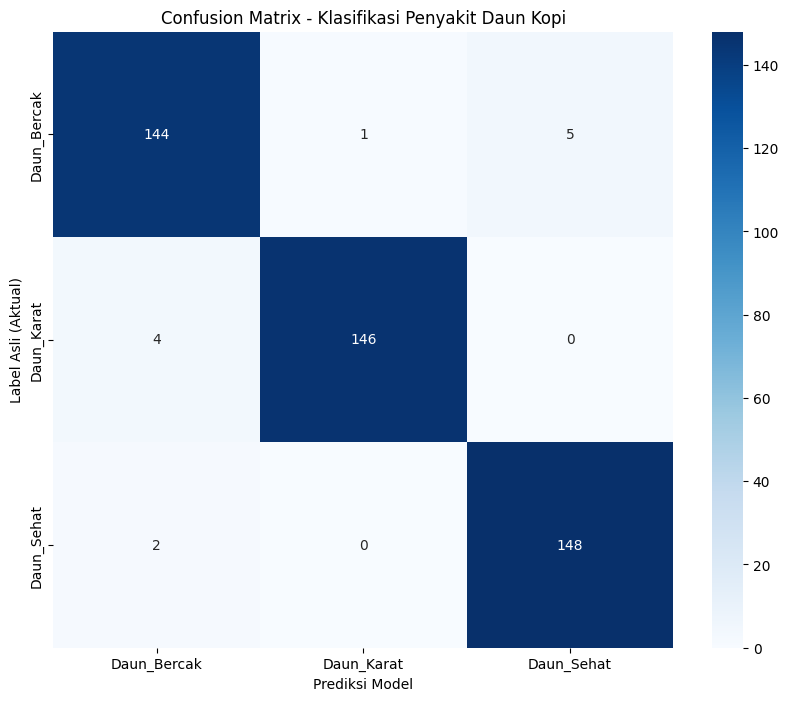

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Lakukan prediksi pada Test Set
print("Sedang melakukan prediksi pada data test...")
predictions = trainer.predict(prepared_ds["test"])

# 2. Ambil hasil prediksi (logits) dan label asli
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# 3. Tampilkan Classification Report (Precision, Recall, F1-Score)
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(true_labels, preds, target_names=labels))

# 4. Buat Confusion Matrix
cm = confusion_matrix(true_labels, preds)

# 5. Visualisasi Confusion Matrix dengan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Aktual)')
plt.title('Confusion Matrix - Klasifikasi Penyakit Daun Kopi')
plt.show()

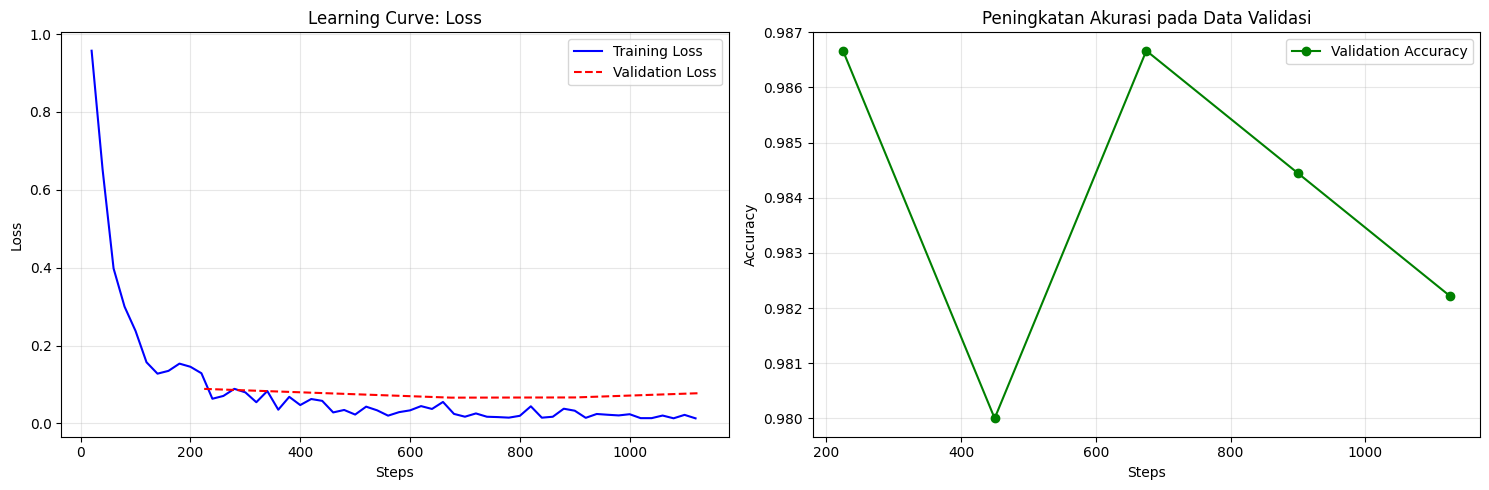

In [ ]:
# Mengambil data history dari trainer
history = trainer.state.log_history

# Mengekstrak data Training Loss
train_loss = []
train_steps = []
for x in history:
    if 'loss' in x:
        train_loss.append(x['loss'])
        train_steps.append(x['step'])

# Mengekstrak data Validation (Loss & Accuracy)
val_loss = []
val_acc = []
val_steps = []
for x in history:
    if 'eval_loss' in x:
        val_loss.append(x['eval_loss'])
        val_acc.append(x['eval_accuracy'])
        val_steps.append(x['step'])

# Plotting Grafik
plt.figure(figsize=(15, 5))

# Grafik 1: Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(val_steps, val_loss, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Grafik 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_steps, val_acc, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Peningkatan Akurasi pada Data Validasi')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
results = trainer.evaluate(prepared_ds["test"])
print("Test set accuracy:", results.get("eval_accuracy", None))


Test set accuracy: 0.9733333333333334


In [ ]:
from PIL import Image

img_path = os.path.join(data_root, 'test', labels[0], os.listdir(os.path.join(data_root, 'test', labels[0]))[0])
image = Image.open(img_path).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt").to(model.device)
with torch.no_grad():
    logits = model(**inputs).logits
    pred_class = logits.argmax(-1).item()
print("Prediksi kelas:", model.config.id2label[str(pred_class)])


Prediksi kelas: Daun_Bercak


##**Prediksi Gambar secara langsung**

Silakan upload gambar daun kopi (file .jpg atau .png)


Saving daun kopi sehatt.jpg to daun kopi sehatt.jpg


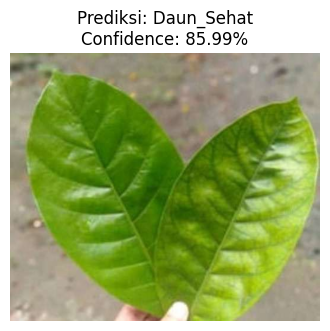

In [ ]:
from google.colab import files
from PIL import Image
import torch

# 1. Upload Gambar dari Komputer
print("Silakan upload gambar daun kopi (file .jpg atau .png)")
uploaded = files.upload()

# Ambil nama file yang baru diupload
filename = next(iter(uploaded))

# 2. Proses Gambar
image = Image.open(filename).convert("RGB")
inputs = image_processor(images=image, return_tensors="pt").to(model.device)

# 3. Prediksi
with torch.no_grad():
    logits = model(**inputs).logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[str(predicted_class_idx)]
    confidence = torch.nn.functional.softmax(logits, dim=-1).max().item()

# 4. Tampilkan Hasil
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis('off')
plt.title(f"Prediksi: {predicted_label}\nConfidence: {confidence:.2%}")
plt.show()

## LoRA Fine-Tuning dan Explainable AI (XAI)

In [ ]:
import shutil
from peft import LoraConfig, get_peft_model, TaskType
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
import os

# --- Path & label ---
destination_path = '/content/drive/MyDrive/semester 7/ML Teori/Dataset/'
data_root = os.path.join(destination_path, 'dataset_coffee_split')
labels = ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']

for split in ['train', 'val', 'test']:
    print(split, ":", os.listdir(os.path.join(data_root, split)))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

model_name = 'google/vit-base-patch16-224-in21k'
image_processor = ViTImageProcessor.from_pretrained(model_name)

# --- Unzip checkpoint lama (hasil training full ViT) ---
zip_path = os.path.join(destination_path, 'vit-daunkopi-checkpoints.zip')
extract_dir = '/content/vit-daunkopi-checkpoints'

# Ensure clean extraction
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
shutil.unpack_archive(zip_path, extract_dir)

# CORRECTED: checkpoint_dir should point directly to extract_dir as files are unpacked there
checkpoint_dir = extract_dir

# --- Load model dari checkpoint (ini sudah ViT yang terlatih) ---
base_model = ViTForImageClassification.from_pretrained(
    checkpoint_dir,
    num_labels=len(labels),
    id2label={str(i): lbl for i, lbl in enumerate(labels)},
    label2id={lbl: str(i) for i, lbl in enumerate(labels)}
)

# --- Pilih TaskType yg sesuai (robust) ---
try:
    task_type = TaskType.IMAGE_CLASSIFICATION
except AttributeError:
    # Kalau PEFT versi lama tidak punya IMAGE_CLASSIFICATION
    task_type = TaskType.SEQ_CLS

# --- Konfigurasi LoRA ---
lora_config = LoraConfig(
    task_type=task_type,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"]  # tiga modul attention
)

# --- Bungkus model dengan LoRA ---
model_lora = get_peft_model(base_model, lora_config)
model_lora.to(device)

# Cek berapa parameter yang trainable
model_lora.print_trainable_parameters()

train : ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
val : ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
test : ['Daun_Karat', 'Daun_Sehat', 'Daun_Bercak']
Device: cpu
trainable params: 444,675 || all params: 86,245,638 || trainable%: 0.5156


In [ ]:
from datasets import load_dataset

data_files = {
    "train": os.path.join(data_root, "train", "**"),
    "validation": os.path.join(data_root, "val", "**"),
    "test": os.path.join(data_root, "test", "**")
}
raw_ds = load_dataset("imagefolder", data_files=data_files)
print(raw_ds)
print("Label di dataset:", raw_ds["train"].features["label"].names)

Resolving data files:   0%|          | 0/3600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/450 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/450 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3600
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 450
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 450
    })
})
Label di dataset: ['Daun_Bercak', 'Daun_Karat', 'Daun_Sehat']


Training LoRa dan Evaluasi Akurasi
- Mengatur training arguments khusus untuk LoRA (learning rate sedikit lebih besar, epoch lebih sedikit).

- Melatih model ViT + LoRA menggunakan Trainer.

- Mengevaluasi model pada test set dan menampilkan akurasi.

In [ ]:
from PIL import Image

def transform(example):
    img = example["image"].convert("RGB")
    inputs = image_processor(img, return_tensors="pt")
    inputs = {k: v.squeeze() for k, v in inputs.items()}  # hilangkan dim batch
    inputs["labels"] = example["label"]
    return inputs

prepared_ds = {}
for split in ["train", "validation", "test"]:
    prepared_ds[split] = raw_ds[split].map(
        transform,
        remove_columns=["image"],
        batched=False
    )

from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

training_args = TrainingArguments(
    output_dir="/content/vit-lora-daunkopi-checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # LoRA biasanya cukup lebih sedikit epoch
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,              # boleh sedikit lebih besar daripada full fine-tune
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels_np = eval_pred
    preds = logits.argmax(-1)
    return {"accuracy": accuracy_score(labels_np, preds)}

trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer_lora.train()

results_lora = trainer_lora.evaluate(prepared_ds["test"])
print("Test set accuracy (ViT + LoRA):", results_lora.get("eval_accuracy", None))


Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/tmp/ipython-input-1414067576.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.004100,0.024493,0.993333
2,0.002800,0.025306,0.993333
3,0.034300,0.025799,0.993333


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test set accuracy (ViT + LoRA): 0.9977777777777778


### Evaluasi Lanjutan Model LoRA: Classification Report & Confusion Matrix

Bagian ini memakai variabel seperti model_inference, test_loader, DEVICE, class_names yang tidak tampak didefinisikan di snippet yang kamu kirim. Secara konsep:

- Menjalankan model LoRA pada seluruh batch test (melalui test_loader).

- Menyimpan label asli (y_true_lora) dan label prediksi (y_pred_lora).

- Menghasilkan classification report dan confusion matrix khusus untuk model LoRA.

- Menampilkan confusion matrix dengan colormap berbeda (misalnya Greens) sebagai pembanding dengan model sebelumnya.

Sedang menguji Model LoRA pada data Test...


Evaluasi LoRA: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


     CLASSIFICATION REPORT (VERSI LORA)
              precision    recall  f1-score   support

 Daun_Bercak     0.9595    0.9467    0.9530       150
  Daun_Karat     0.9865    0.9733    0.9799       150
  Daun_Sehat     0.9610    0.9867    0.9737       150

    accuracy                         0.9689       450
   macro avg     0.9690    0.9689    0.9689       450
weighted avg     0.9690    0.9689    0.9689       450



<Figure size 1000x800 with 0 Axes>

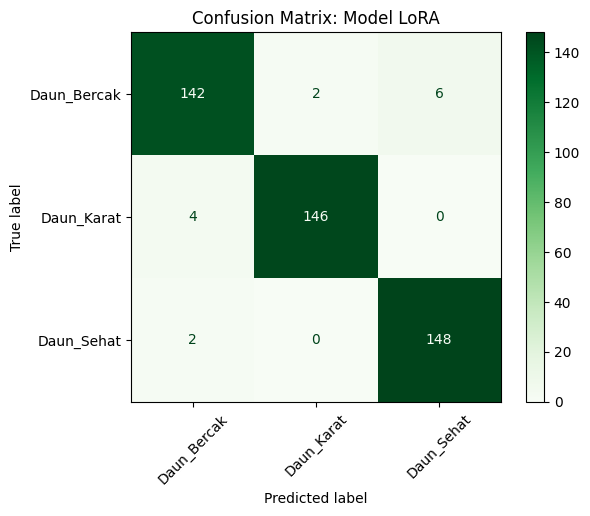

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- 1. JALANKAN PREDIKSI MENGGUNAKAN MODEL LORA ---
print("Sedang menguji Model LoRA pada data Test...")

# Pastikan model dalam mode evaluasi
model_inference.eval()

y_true_lora = []
y_pred_lora = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluasi LoRA"):
        images, labels = batch
        images = images.to(DEVICE)

        # PENTING: Di sini kita pakai 'model_inference' (yang ada LoRA-nya)
        outputs = model_inference(pixel_values=images)

        # Ambil prediksi
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Simpan ke list
        y_true_lora.extend(labels.cpu().numpy())
        y_pred_lora.extend(predictions.cpu().numpy())

# --- 2. TAMPILKAN LAPORAN KLASIFIKASI (LoRA) ---
print("\n" + "="*40)
print("     CLASSIFICATION REPORT (VERSI LORA)")
print("="*40)

# target_names=class_names diambil dari variabel sebelumnya
print(classification_report(y_true_lora, y_pred_lora, target_names=class_names, digits=4))

# --- 3. TAMPILKAN CONFUSION MATRIX (LoRA) ---
cm_lora = confusion_matrix(y_true_lora, y_pred_lora)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lora, display_labels=class_names)

# Saya ganti warnanya jadi 'Greens' supaya beda dengan model pertama
disp.plot(cmap='Greens', values_format='d', xticks_rotation=45)
plt.title('Confusion Matrix: Model LoRA')
plt.show()

### XAI: Grad-CAM untuk ViT / ViT + LoRA

Bagian kelas VitGradCAM:

- Mengambil modul inti ViT dari model (baik model biasa maupun yang sudah dibungkus LoRA).

- Mendaftarkan forward hook dan backward hook pada layer encoder terakhir untuk menangkap:

  - Aktivasi (activations),

   - Gradien (gradients).

Fungsi generate_cam:

- Melakukan forward pass dan backward terhadap kelas target.

- Menghitung peta pentingnya (CAM) berdasarkan gradien dan aktivasi.

- Mengubah token patch menjadi peta 2D dan meng-resize ke ukuran gambar asli.

Fungsi overlay_cam:

- Menggabungkan heatmap Grad-CAM dengan gambar asli untuk menunjukkan area yang paling berkontribusi pada keputusan model.

Fungsi generate_xai_explanation:

- Memberikan penjelasan tekstual sederhana berdasarkan kelas yang terdeteksi (Daun_Bercak, Daun_Karat, Daun_Sehat).

Fungsi explain_image_with_gradcam:

- Melakukan prediksi kelas.

- Menghasilkan peta Grad-CAM.

- Mengembalikan peta Grad-CAM dan penjelasan tekstual XAI.

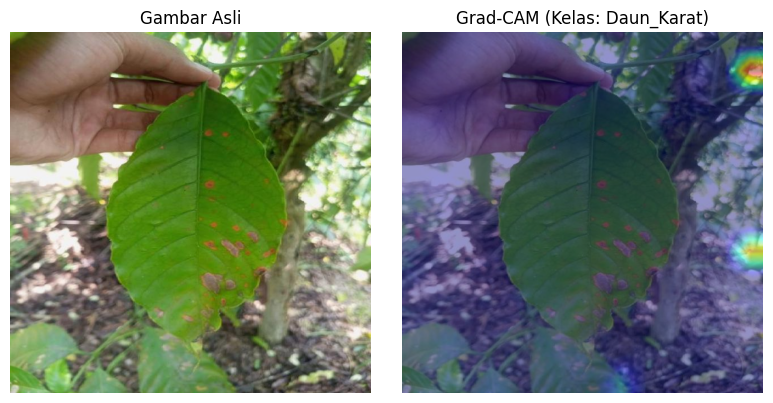

Penjelasan XAI: Penyakit karat daun kopi disebabkan oleh infeksi jamur Hemileia vastatrix, yang menyebabkan daun kopi menguning dan rontok.


In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor

class VitGradCAM:
    def __init__(self, model, image_processor):
        """
        model: bisa ViTForImageClassification biasa atau PeftModel (ViT + LoRA)
        image_processor: ViTImageProcessor
        """
        self.model = model
        self.image_processor = image_processor
        self.model.eval()

        # Deteksi modul ViT di dalam model
        vit_module = getattr(self.model, "vit", None)
        if vit_module is None and hasattr(self.model, "base_model"):
            vit_module = getattr(self.model.base_model, "vit", None)
        if vit_module is None:
            raise ValueError("Tidak bisa menemukan modul .vit di dalam model. Cek struktur model.")

        # Ambil output layer terakhir encoder
        target_layer = vit_module.encoder.layer[-1].output

        # Menangkap activations dan gradients dari model
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, image: Image.Image, label_idx: int = None, show: bool = True):
        device = next(self.model.parameters()).device

        # Preprocess image
        inputs = self.image_processor(images=image, return_tensors="pt").to(device)
        self.model.zero_grad()

        # Prediksi dan backward untuk mendapatkan Grad-CAM
        outputs = self.model(**inputs)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]

        if label_idx is None:
            label_idx = logits.argmax(-1).item()

        score = logits[:, label_idx]
        score.backward(retain_graph=True)

        # Grad-CAM
        grads = self.gradients
        activations = self.activations
        weights = grads.mean(dim=1, keepdim=True)
        cam_tokens = (activations * weights).sum(dim=-1).squeeze(0)

        # Hilangkan CLS token
        cam_tokens = cam_tokens[1:]

        num_patches = cam_tokens.shape[0]
        h = w = int(np.sqrt(num_patches))
        cam = cam_tokens.reshape(h, w).detach().cpu().numpy()

        # Normalize
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)

        # Resize cam to original image size
        cam = cv2.resize(cam, image.size)

        if show:
            self.overlay_cam(image, cam, label_idx)

        return cam

    def overlay_cam(self, image: Image.Image, cam: np.ndarray, label_idx: int):
        img_np = np.array(image)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay heatmap pada gambar
        overlay = (0.4 * heatmap + 0.6 * img_np).astype(np.uint8)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title("Gambar Asli")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay)
        plt.axis("off")
        label_name = self.model.config.id2label[str(label_idx)]
        plt.title(f"Grad-CAM (Kelas: {label_name})")

        plt.tight_layout()
        plt.show()

    def generate_xai_explanation(self, label_idx: int):
        # Penjelasan berbasis XAI untuk penyakit kopi
        disease_explanations = {
            "Daun_Bercak": "Penyakit bercak daun disebabkan oleh infeksi jamur yang menyebabkan bercak coklat pada daun kopi.",
            "Daun_Karat": "Penyakit karat daun kopi disebabkan oleh infeksi jamur Hemileia vastatrix, yang menyebabkan daun kopi menguning dan rontok.",
            "Daun_Sehat": "Daun kopi yang sehat memiliki warna hijau cerah dan tidak ada tanda-tanda penyakit atau infeksi."
        }

        disease_name = self.model.config.id2label[str(label_idx)]
        return disease_explanations.get(disease_name, "Tidak ada penjelasan untuk kelas ini.")

# Implementasi Grad-CAM untuk penjelasan penyakit
def explain_image_with_gradcam(image: Image.Image, model, image_processor):
    gradcam = VitGradCAM(model, image_processor)
    label_idx = model(**image_processor(images=image, return_tensors="pt").to(device)).logits.argmax(-1).item()
    cam = gradcam.generate_cam(image, label_idx)

    # Tampilkan hasil Grad-CAM dan penjelasan XAI
    explanation = gradcam.generate_xai_explanation(label_idx)
    print(f"Penjelasan XAI: {explanation}")

    return cam, explanation

# Implementasi Grad-CAM dan penjelasan
image_path = "/content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split/val/Daun_Karat/Daun_Karat_0081.jpg"  # Ganti dengan path gambar yang sesuai
image = Image.open(image_path)
cam, explanation = explain_image_with_gradcam(image, model_lora, image_processor)


### XAI + Groq (Penjelasan tambahan dengan LLM)

Bagian ini:

- Menggunakan API Groq (model llama-3.3-70b-versatile) untuk menghasilkan penjelasan tekstual yang lebih mendalam tentang penyakit yang terdeteksi.

- Fungsi get_additional_explanation(disease_name):

    Mengirim prompt ke model bahasa untuk meminta penjelasan penyakit dan cara penanganan.

- Fungsi generate_xai_explanation(predicted_label):

    Menggabungkan penjelasan singkat (manual) + penjelasan tambahan dari Groq.

- Fungsi explain_with_gradcam_and_xai:

    - Melakukan prediksi kelas,

    - Membuat Grad-CAM untuk visual interpretasi,

    - Mengambil penjelasan penyakit dari rule-based + Groq,

    - Menampilkan hasil prediksi, confidence, dan penjelasan XAI.

- Di akhir, dipilih satu gambar dari folder val lalu:

    - Dibuat peta Grad-CAM,

    - Dibuat overlay antara gambar asli dengan heatmap,

    - Penjelasan tambahan dari Groq ditampilkan di konsol.

Using image: /content/drive/MyDrive/semester 7/ML Teori/Dataset/dataset_coffee_split/val/Daun_Bercak/Daun_Bercak_1804.jpg


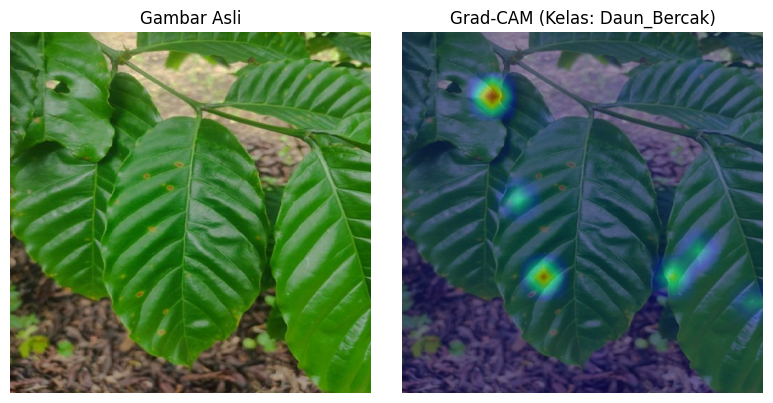

Prediksi: Daun_Bercak (Confidence: 99.69%)
Penjelasan XAI: Penyakit bercak daun disebabkan oleh infeksi jamur yang menyebabkan bercak coklat pada daun kopi.
Penjelasan Tambahan: Penyakit Daun Bercak (Coffee Leaf Spot) adalah salah satu penyakit yang paling umum dan merusak tanaman kopi, terutama pada varietas Arabika dan Robusta. Penyakit ini disebabkan oleh jamur (fungi) dari genus Cercospora, yang tumbuh pada daun tanaman kopi dan menyebabkan bercak-bercak kecil berwarna coklat atau hitam.

**Gejala Penyakit Daun Bercak:**

1. Bercak-bercak kecil berwarna coklat atau hitam pada daun tanaman kopi, biasanya dengan diameter 1-5 mm.
2. Bercak-bercak tersebut dapat bergabung dan membentuk bercak yang lebih besar, sehingga daun menjadi rusak dan menguning.
3. Daun yang terinfeksi dapat rontok, sehingga tanaman kopi kehilangan kemampuan fotosintesis dan produksi buah.
4. Tanaman kopi yang terinfeksi dapat menjadi lemah dan rentan terhadap serangan hama lainnya.

**Penyebab Penyakit Daun Ber

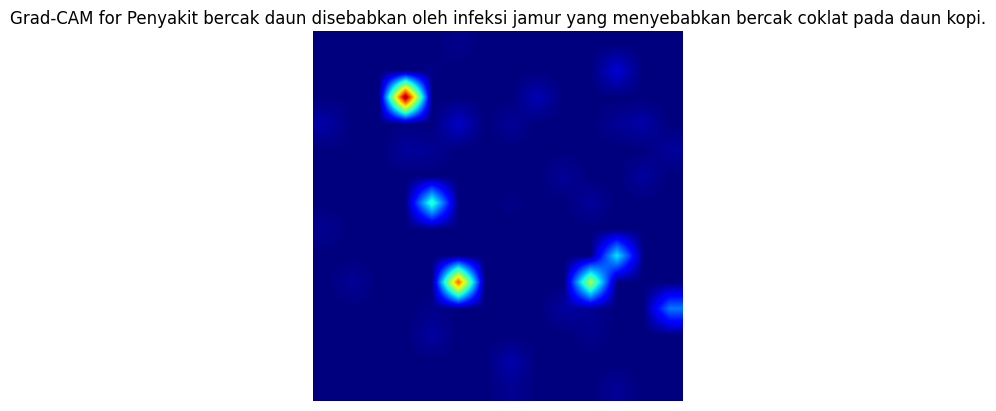

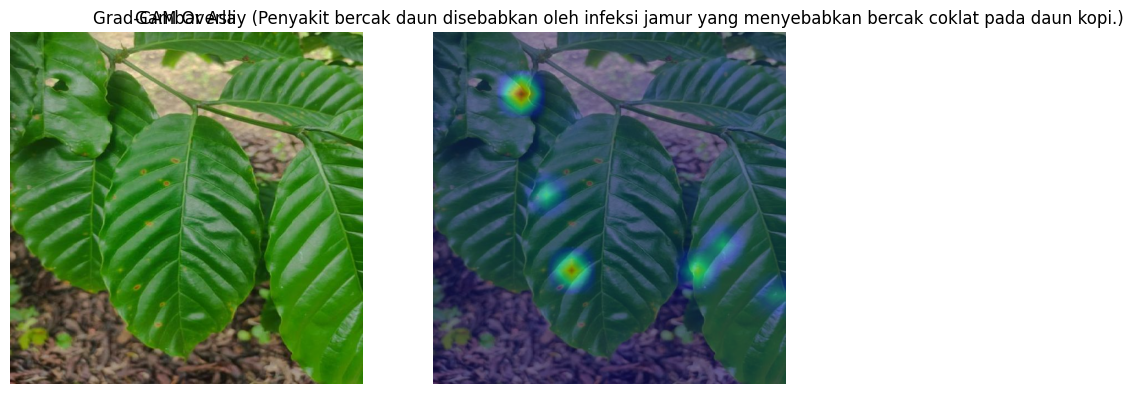

<Figure size 640x480 with 0 Axes>


Penjelasan Tambahan dari Groq:
Penyakit Daun Bercak (Coffee Leaf Spot) adalah salah satu penyakit yang paling umum dan merusak tanaman kopi, terutama pada varietas Arabika dan Robusta. Penyakit ini disebabkan oleh jamur (fungi) dari genus Cercospora, yang tumbuh pada daun tanaman kopi dan menyebabkan bercak-bercak kecil berwarna coklat atau hitam.

**Gejala Penyakit Daun Bercak:**

1. Bercak-bercak kecil berwarna coklat atau hitam pada daun tanaman kopi, biasanya dengan diameter 1-5 mm.
2. Bercak-bercak tersebut dapat bergabung dan membentuk bercak yang lebih besar, sehingga daun menjadi rusak dan menguning.
3. Daun yang terinfeksi dapat rontok, sehingga tanaman kopi kehilangan kemampuan fotosintesis dan produksi buah.
4. Tanaman kopi yang terinfeksi dapat menjadi lemah dan rentan terhadap serangan hama lainnya.

**Penyebab Penyakit Daun Bercak:**

1. Jamur Cercospora: Jamur ini adalah penyebab utama penyakit Daun Bercak pada tanaman kopi.
2. Kelembaban tinggi: Kelembaban yang tinggi 

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os
from groq import Groq
import numpy as np

# NOTE: Replace with your actual API key for Groq
groq_api_key = "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"
client = Groq(api_key=groq_api_key)

# Example Groq API call setup (assuming the text generation function is available in Groq)
def get_additional_explanation(disease_name):
    prompt = f"Jelaskan secara mendalam mengenai penyakit {disease_name} pada tanaman kopi dan bagaimana cara menanganinya."
    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",  # Use a supported Groq model
        messages=[
            {"role": "system", "content": "Anda adalah asisten yang membantu menjelaskan penyakit tanaman."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=700  # Adding max_tokens to get a more detailed explanation
    )

    return response.choices[0].message.content.strip()

# Penjelasan untuk kelas yang terdeteksi berdasarkan model LoRA
def generate_xai_explanation(predicted_label):
    disease_explanations = {
        "Daun_Bercak": "Penyakit bercak daun disebabkan oleh infeksi jamur yang menyebabkan bercak coklat pada daun kopi.",
        "Daun_Karat": "Penyakit karat daun kopi disebabkan oleh infeksi jamur Hemileia vastatrix, yang menyebabkan daun kopi menguning dan rontok.",
        "Daun_Sehat": "Daun kopi yang sehat memiliki warna hijau cerah dan tidak ada tanda-tanda penyakit atau infeksi."
    }

    # The predicted_label is already the string name (e.g., 'Daun_Bercak')
    disease_name = disease_explanations.get(predicted_label, "Tidak ada penjelasan untuk kelas ini.")

    # Get additional explanation from Groq
    additional_explanation = get_additional_explanation(predicted_label)

    return disease_name, additional_explanation

# Fungsi untuk menampilkan penjelasan berbasis XAI dan Grad-CAM
def explain_with_gradcam_and_xai(image, model, image_processor):
    # Prediksi kelas
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predicted_label = model.config.id2label[str(predicted_class_idx)]

    # Grad-CAM untuk visualisasi
    gradcam = VitGradCAM(model, image_processor)
    cam = gradcam.generate_cam(image, label_idx=predicted_class_idx, show=True)

    # Penjelasan XAI
    disease_name, additional_explanation = generate_xai_explanation(predicted_label)

    # Print explanation only once
    print(f"Prediksi: {predicted_label} (Confidence: {torch.nn.functional.softmax(logits, dim=-1).max().item():.2%})")
    print(f"Penjelasan XAI: {disease_name}")
    print(f"Penjelasan Tambahan: {additional_explanation}")

    return cam, disease_name, additional_explanation

# Dynamically select an existing image file from the specified class folder
class_folder_path = os.path.join(data_root, 'val', labels[0])
existing_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if existing_files:
    sample_filename = existing_files[0]  # Pick the first image file found
    image_path = os.path.join(class_folder_path, sample_filename)
    print(f"Using image: {image_path}")
    image = Image.open(image_path)

    # Ensure 'device' is defined and accessible
    if 'device' not in globals():
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Call explain_with_gradcam_and_xai function just once to avoid duplication
    cam, disease_name, explanation = explain_with_gradcam_and_xai(image, model_lora, image_processor)

    # Saving Grad-CAM result
    plt.imshow(cam, cmap='jet')
    plt.title(f"Grad-CAM for {disease_name}")
    plt.axis('off')
    plt.savefig("/content/grad_cam_result.png")
    plt.show()

    # Saving original image and Grad-CAM overlay
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Gambar Asli")
    plt.axis('off')

    # Image with Grad-CAM overlay
    plt.subplot(1, 2, 2)
    # Blend the heatmap with the original image
    heatmap = plt.cm.jet(cam)
    heatmap = heatmap[:, :, :3]  # Remove alpha channel
    image_array = np.array(image).astype(np.float32)
    overlay_img = Image.fromarray(((image_array * 0.6 + heatmap * 0.4 * 255).clip(0, 255)).astype('uint8'))

    plt.imshow(overlay_img)
    plt.title(f"Grad-CAM Overlay ({disease_name})")
    plt.axis('off')
    plt.show()

    # Save the overlay image
    plt.savefig("/content/grad_cam_overlay_result.png")
    plt.show()

    # Display the additional explanation from Groq
    print("\nPenjelasan Tambahan dari Groq:")
    print(explanation)

else:
    print(f"Error: No image files found in {class_folder_path}. Cannot proceed with explanation.")
